In [73]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F 
import random
%matplotlib inline 

In [74]:
words =  open("names.txt").read().splitlines()

In [75]:
len(words)

32033

In [76]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

In [77]:
block_size = 8

def build_dataset(word):
    X, Y = [], []

    for w in word:
        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [78]:
class Linear:

    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in,fan_out)) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + [self.bias] if self.bias is not None else []

class Tanh():

    def __call__(self, x):
        return torch.tanh(x)
    
    def parameters(self):
        return []
    
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-05, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim) 
        self.beta = torch.zeros(dim)
        self.training = True
        self.running_mean = torch.zeros(dim)
        self.running_std = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_std
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean 
                self.running_std  = (1 - self.momentum) * self.running_std + self.momentum * xvar 
        return self.out 
    
    def parameters(self):
        return [self.gamma,self.beta]
    
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:

    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self,):
        return [p for layer in self.layers for p in layer.parameters()]



In [79]:
torch.manual_seed(42);

In [80]:
vocab_size = 27
n_emb = 10
n_hidden = 200

In [81]:
model = Sequential([
    Embedding(vocab_size, n_emb),
    Flatten(),
    Linear(block_size * n_emb, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

In [82]:
print(sum(p.nelement() for p in model.parameters()))

22297


In [83]:
for p in model.parameters():
    p.requires_grad = True

In [84]:
max_steps = 200000
batch_size = 32
lossi = []

In [85]:
for k in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward
    x = Xb
    logits = model(x)
    
    loss = F.cross_entropy(logits, Yb)
    lossi.append(loss)
    # backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    lr = 0.1 if k < 100000 else 0.01
    for p in model.parameters():
        p.data += -lr * p.grad 
    
    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d}: {loss.item(): .4f}")


      0/ 200000:  3.2847
  10000/ 200000:  2.0647
  20000/ 200000:  1.9722
  30000/ 200000:  2.0948
  40000/ 200000:  1.9738
  50000/ 200000:  2.1287
  60000/ 200000:  2.3574
  70000/ 200000:  1.9131
  80000/ 200000:  2.0735
  90000/ 200000:  2.0968
 100000/ 200000:  1.4963
 110000/ 200000:  2.0798
 120000/ 200000:  2.2252
 130000/ 200000:  2.1441
 140000/ 200000:  2.1807
 150000/ 200000:  1.9785
 160000/ 200000:  1.6792
 170000/ 200000:  2.1398
 180000/ 200000:  1.7523
 190000/ 200000:  1.9014


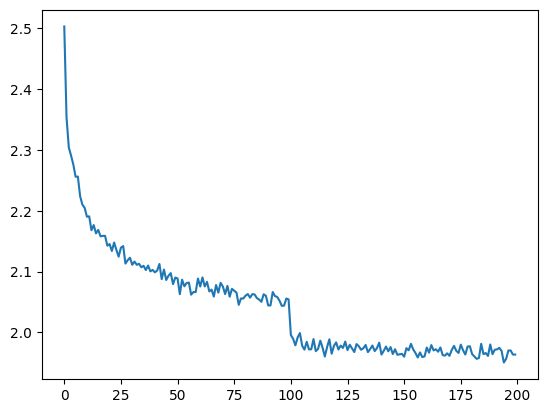

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [87]:
for layer in model.layers:
    layer.training = False

In [88]:
@torch.no_grad()
def split_loss(split):
    x,y  = {
        'train': (Xtr, Ytr),
        'valid': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('valid')

train 1.9251518249511719
valid 2.037414312362671


In [89]:
context = [0] * 8
torch.tensor([context]).shape

torch.Size([1, 8])

In [90]:
for _ in range(20):

    out = []
    context = [0] * block_size

    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in out)) 

melae.
lynn.
gwosen.
macayl.
zakayah.
elson.
taion.
dayana.
haziyah.
hamilin.
dakys.
pracelyne.
ellandon.
maceel.
hamby.
dencensuh.
card.
malizan.
ronni.
gilia.


## Wave Net Implementation

In [ ]:
class Linear:

    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in,fan_out)) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + [self.bias] if self.bias is not None else []

class Tanh():

    def __call__(self, x):
        return torch.tanh(x)
    
    def parameters(self):
        return []
    
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-05, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim) 
        self.beta = torch.zeros(dim)
        self.training = True
        self.running_mean = torch.zeros(dim)
        self.running_std = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_std
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean 
                self.running_std  = (1 - self.momentum) * self.running_std + self.momentum * xvar 
        return self.out 
    
    def parameters(self):
        return [self.gamma,self.beta]
    
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:

    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self,):
        return [p for layer in self.layers for p in layer.parameters()]
